# Imports

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initialise GPU

In [40]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading and Pre-processing

In [41]:
class MIMICDataProcessor:
    def __init__(self, file_path, batch_size=64):
        self.file_path = file_path
        self.batch_size = batch_size
        self.scaler = StandardScaler()

        # Load and preprocess the data
        self.df = pd.read_csv(file_path)

        # Replace all missing values with 0
        self.df.fillna(0, inplace=True)

        # Features
        self.X = self.df[['upper_respiratory_infections', 'influenza_pneumonia', 'acute_lower_respiratory_infections', 'chronic_lower_respiratory_diseases',
                          'lung_diseases_due_to_external_agents', 'other_respiratory_diseases', 'InvasiveVent', 'SupplementalOxygen', 'HFNC',
                          'NonInvasiveVent', 'Tracheostomy', 'None', 'avg_uo_24hr', 'avg_creatinine_max', 'max_renal_uo_24hr', 'max_renal_creatinine_max',
                          'avg_pao2fio2ratio_novent', 'avg_pao2fio2ratio_vent', 'max_respiration_pao2fio2ratio_novent', 'max_respiration_pao2fio2ratio_vent', 'avg_gcs_min', 'max_cns_gcs_min',
                          'sofa_score', 'suspected_infection', 'one_vasopressor', 'multi_vasopressor']]

        # Vanilla Concepts
        self.C = self.df[['c_rsp_mod', 'c_rsp_svr', 'c_vent_low', 'c_vent_moderate', 'c_vent_high', 'c_max_renf_moderate', 'c_max_renf_severe',
                          'c_avg_renf_moderate', 'c_avg_renf_severe', 'c_max_respf_moderate', 'c_max_respf_severe', 'c_avg_respf_moderate',
                          'c_avg_respf_severe', 'c_max_cnsf_moderate', 'c_max_cnsf_severe', 'c_avg_cnsf_moderate', 'c_avg_cnsf_severe',
                          'c_sepsis3', 'c_shock']]

        # Additional LLM Concepts
        self.LLM_C = self.df[['ards_detected', 'aspiration_detected', 'bilateral_infiltrates_detected', 'cardiac_arrest_detected',
                          'cardiac_failure_detected', 'pancreatitis_detected', 'pneumonia_detected', 'trali_detected']]

        # Label
        self.Y = self.df['ARDS']

        # Convert to tensors
        self.X_tensor = torch.tensor(self.X.values, dtype=torch.float32)
        self.C_tensor = torch.tensor(self.C.values, dtype=torch.float32)
        self.LLM_C_tensor = torch.tensor(self.LLM_C.values, dtype=torch.float32)
        self.Y_tensor = torch.tensor(self.Y.values, dtype=torch.float32)

        # Normalize the features
        self.X_scaled = self.scaler.fit_transform(self.X)
        self.X_tensor_scaled = torch.tensor(self.X_scaled, dtype=torch.float32)

    def get_features(self):
        return self.X.columns.tolist()

    def get_vanilla_concepts(self):
        return self.C.columns.tolist()

    def get_llm_concepts(self):
        return self.LLM_C.columns.tolist()

    class MIMICDataset(Dataset):
        def __init__(self, x, c, llm_c, y):
            self.x = x
            self.c = c
            self.llm_c = llm_c
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.x[idx], self.c[idx], self.llm_c[idx], self.y[idx]


    def create_dataloaders(self):
        # Split the data into temporary (80%) and test (20%) sets
        X_temp, X_test, C_temp, C_test, LLM_C_temp, LLM_C_test, Y_temp, Y_test = train_test_split(
            self.X_tensor_scaled, self.C_tensor, self.LLM_C_tensor, self.Y_tensor, test_size=0.20, random_state=42)

        # Further split the temporary data into training (75% of temporary) and validation (25% of temporary) sets
        X_train, X_val, C_train, C_val, LLM_C_train, LLM_C_val, Y_train, Y_val = train_test_split(
            X_temp, C_temp, LLM_C_temp, Y_temp, test_size=0.25, random_state=42)

        train_dataset = self.MIMICDataset(X_train, C_train, LLM_C_train, Y_train)
        val_dataset = self.MIMICDataset(X_val, C_val, LLM_C_val, Y_val)
        test_dataset = self.MIMICDataset(X_test, C_test, LLM_C_test, Y_test)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader

# Model

In [42]:
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(MultiLabelNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, num_labels)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))  # Sigmoid activation to output probabilities for each label
        return x

class CombinedNN(nn.Module):
    def __init__(self, num_features, num_vanilla_concepts, num_llm_concepts, num_labels):
        super(CombinedNN, self).__init__()
        self.vanilla_c_predictor = MultiLabelNN(num_features, num_vanilla_concepts)
        self.label_predictor = MultiLabelNN(num_vanilla_concepts + num_llm_concepts, num_labels)

    def forward(self, x, llm_c):
        vanilla_c = self.vanilla_c_predictor(x)
        combined_c = torch.cat((vanilla_c, llm_c), dim=1)
        y_pred = self.label_predictor(combined_c)
        return y_pred, vanilla_c

# Training

In [43]:
def train_combined_model(x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, weight_decay=0.01):
    torch.manual_seed(25)

    model = CombinedNN(num_features=x_size, num_vanilla_concepts=vanilla_c_size, num_llm_concepts=llm_c_size, num_labels=y_size).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    epochs_count = []
    train_loss_values, val_loss_values = [], []
    vanilla_c_predictions, label_predictions = [], []
    vanilla_c_val_predictions, label_val_predictions = [], []
    ground_truth_val_vanilla_c, ground_truth_val_label = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")  # Print current epoch
        epochs_count.append(epoch)

        # Training Loop
        model.train()
        running_loss = 0.0

        for i, batch in enumerate(train_loader):
            x, vanilla_c, llm_c, y = batch
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            # Forward pass
            optimizer.zero_grad()
            y_pred, vanilla_c_pred = model(x, llm_c)
            vanilla_c_predictions.append(vanilla_c_pred.detach().cpu().numpy())
            label_predictions.append(y_pred.detach().cpu().numpy())
            loss = criterion(y_pred, y.unsqueeze(1).float())

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss value
            running_loss += loss.item()

        train_loss_values.append(running_loss / len(train_loader))

        # Validation Loop
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for x, vanilla_c, llm_c, y in val_loader:
                x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

                ground_truth_val_vanilla_c.append(vanilla_c.cpu())
                ground_truth_val_label.append(y.cpu())

                # Forward pass through model
                y_pred, vanilla_c_pred = model(x, llm_c)
                vanilla_c_val_predictions.append(vanilla_c_pred.detach().cpu().numpy())
                label_val_predictions.append(y_pred.detach().cpu().numpy())
                loss = criterion(y_pred, y.unsqueeze(1).float())

                # Accumulate loss value
                running_val_loss += loss.item()

        val_loss_values.append(running_val_loss / len(val_loader))

        scheduler.step()

    return model, epochs_count, train_loss_values, val_loss_values, vanilla_c_predictions, label_predictions, vanilla_c_val_predictions, label_val_predictions, ground_truth_val_vanilla_c, ground_truth_val_label

In [44]:
# Specify Parameters
x_size = 26
vanilla_c_size = 19
llm_c_size = 8
y_size = 1
learning_rate = 0.01
epochs = 60
weight_decay = 0.01

# Load Data
file_path = '/content/augmented-ards-data.csv'
data_processor = MIMICDataProcessor(file_path, batch_size=64)
train_loader, val_loader, test_loader = data_processor.create_dataloaders()

regularised_model, epochs_count, train_loss_values, val_loss_values, vanilla_c_predictions, label_predictions, vanilla_c_val_predictions, label_val_predictions, ground_truth_val_vanilla_c, ground_truth_val_label = train_combined_model(x_size, vanilla_c_size, llm_c_size, y_size, learning_rate, epochs, train_loader, val_loader, weight_decay)

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


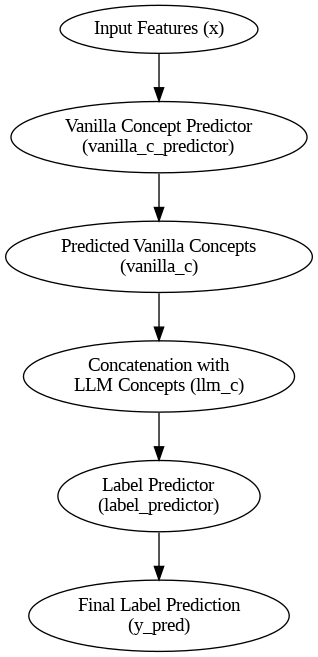

In [45]:
from graphviz import Digraph
from IPython.display import Image

# Create the graph
dot = Digraph()

dot.node('A', 'Input Features (x)')
dot.node('B', 'Vanilla Concept Predictor\n(vanilla_c_predictor)')
dot.node('C', 'Predicted Vanilla Concepts\n(vanilla_c)')
dot.node('D', 'Concatenation with\nLLM Concepts (llm_c)')
dot.node('E', 'Label Predictor\n(label_predictor)')
dot.node('F', 'Final Label Prediction\n(y_pred)')

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])

# Render the graph to a PNG file and display it
dot.render('flowchart', format='png')

# Display the image
Image(filename='flowchart.png')


# Plotting Loss


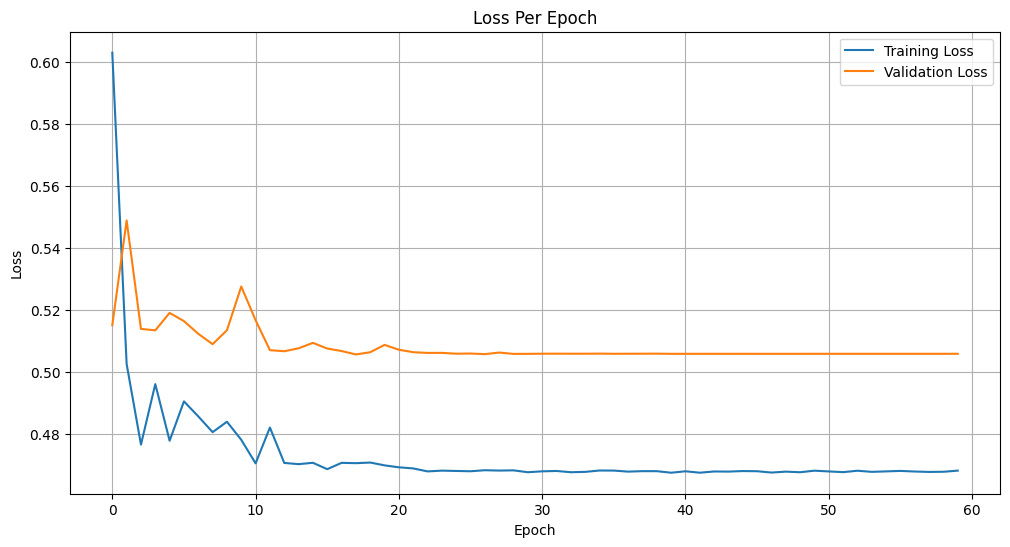

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(epochs_count, train_loss_values, label='Training Loss')
plt.plot(epochs_count, val_loss_values, label='Validation Loss')
plt.title('Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Completeness Score

In [47]:
from sklearn.metrics import mutual_info_score
import numpy as np

def compute_mutual_information(true_labels, predicted_values):
    # Convert the predicted values to binary classes
    predicted_classes = (predicted_values > 0.5).astype(int)
    return mutual_info_score(true_labels, predicted_classes)

# Compute mutual information I(y; c)
def compute_I_y_c(ground_truth_val_y, c_to_y_val_predictions):
    true_values = np.concatenate([gy.numpy() for gy in ground_truth_val_y])
    predicted_values = np.concatenate([py.squeeze() for py in c_to_y_val_predictions])
    return compute_mutual_information(true_values, predicted_values)

# Compute mutual information I(y; c, x)
def compute_I_y_c_x(ground_truth_val_y, x_to_c_val_predictions, c_to_y_val_predictions):
    true_values = np.concatenate([gy.numpy() for gy in ground_truth_val_y])

    # Compute mutual information for each concept and label pair
    predicted_concepts = np.concatenate(x_to_c_val_predictions)
    predicted_labels = np.concatenate([py.squeeze() for py in c_to_y_val_predictions])

    combined_predictions = np.column_stack((predicted_concepts, predicted_labels))

    # Flatten combined_predictions to make it 1D
    combined_predictions_flat = combined_predictions.flatten()

    return mutual_info_score(true_values, combined_predictions_flat[:len(true_values)])

# Compute the Completeness Score
def compute_completeness_score(I_y_c, I_y_c_x):
    return I_y_c / I_y_c_x

# Calculate mutual information
I_y_c = compute_I_y_c(ground_truth_val_label, label_val_predictions)
print(f"Mutual Information I(y; c): {I_y_c}")

I_y_c_x = compute_I_y_c_x(ground_truth_val_label, vanilla_c_val_predictions, label_val_predictions)
print(f"Mutual Information I(y; c, x): {I_y_c_x}")

# Calculate completeness score
completeness_score = compute_completeness_score(I_y_c, I_y_c_x)
print(f"Completeness Score: {completeness_score}")

Mutual Information I(y; c): 0.13640840635676935
Mutual Information I(y; c, x): 0.1864522559293219
Completeness Score: 0.7315996563135038


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


# Validation Evaluation

In [48]:
# Concept Predictor Evaluation
def evaluate_concept_predictor(ground_truth_c, predicted_c, concept_labels):
    results = []
    for i, label in enumerate(concept_labels):
        true_values = np.concatenate([c[:, i] for c in ground_truth_c])
        predicted_values = np.concatenate([c[:, i] for c in predicted_c])

        predicted_classes = (predicted_values > 0.5).astype(int)

        precision = precision_score(true_values, predicted_classes, zero_division=0)
        recall = recall_score(true_values, predicted_classes, zero_division=0)
        f1 = f1_score(true_values, predicted_classes, zero_division=0)
        accuracy = accuracy_score(true_values, predicted_classes)

        results.append({
            "Label": label,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "Accuracy": accuracy
        })
    return pd.DataFrame(results)

# Label Predictor Evaluation
def evaluate_label_predictor(ground_truth_y, predicted_y):
    true_values = np.concatenate(ground_truth_y)
    predicted_values = np.concatenate(predicted_y).squeeze()

    predicted_classes = (predicted_values > 0.5).astype(int)

    precision = precision_score(true_values, predicted_classes)
    recall = recall_score(true_values, predicted_classes)
    f1 = f1_score(true_values, predicted_classes)
    auc = roc_auc_score(true_values, predicted_classes)
    accuracy = accuracy_score(true_values, predicted_classes)

    results = {
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Accuracy": accuracy
    }
    return pd.DataFrame(results, index=["Metrics"])

In [49]:
# Evaluate the concept predictor
vanilla_concept_list = data_processor.C.columns.tolist()
concept_test_results = evaluate_concept_predictor(ground_truth_val_vanilla_c, vanilla_c_val_predictions, vanilla_concept_list)
print("\nValidation Concept Predictor Results:")
print(concept_test_results)

# Evaluate the label predictor
label_test_results = evaluate_label_predictor(ground_truth_val_label, label_val_predictions)
print("\nValidation Label Predictor Results:")
print(label_test_results)


Validation Concept Predictor Results:
                   Label  Precision    Recall  F1 Score  Accuracy
0              c_rsp_mod   0.000000  0.000000  0.000000  0.225248
1              c_rsp_svr   0.188119  0.016667  0.030620  0.801485
2             c_vent_low   0.767327  0.016667  0.032625  0.241584
3        c_vent_moderate   0.000000  0.000000  0.000000  0.868812
4            c_vent_high   0.997525  0.766667  0.866991  0.765347
5    c_max_renf_moderate   0.329208  0.750000  0.457569  0.414604
6      c_max_renf_severe   0.000000  0.000000  0.000000  0.514851
7    c_avg_renf_moderate   0.000000  0.000000  0.000000  0.891089
8      c_avg_renf_severe   0.000000  0.000000  0.000000  0.861386
9   c_max_respf_moderate   0.000000  0.000000  0.000000  0.957921
10    c_max_respf_severe   0.957921  0.783333  0.861875  0.759488
11  c_avg_respf_moderate   0.000000  0.000000  0.000000  0.725248
12    c_avg_respf_severe   0.720297  0.750000  0.734848  0.610149
13   c_max_cnsf_moderate   0.349010  

# Testing Evaluation

In [50]:
# Function to test the model and gather predictions
def test_combined_model(model, test_loader):
    model.eval()
    criterion = nn.BCELoss()

    running_loss = 0.0
    all_y_true = []
    all_y_pred = []
    all_vanilla_c_true = []
    all_vanilla_c_pred = []

    with torch.no_grad():
        for x, vanilla_c, llm_c, y in test_loader:
            x, vanilla_c, llm_c, y = x.to(device), vanilla_c.to(device), llm_c.to(device), y.to(device)

            y_pred, vanilla_c_pred = model(x, llm_c)
            loss = criterion(y_pred, y.unsqueeze(1).float())
            running_loss += loss.item()

            all_y_true.append(y.cpu().numpy())
            all_y_pred.append(y_pred.cpu().numpy())
            all_vanilla_c_true.append(vanilla_c.cpu().numpy())
            all_vanilla_c_pred.append(vanilla_c_pred.cpu().numpy())

    average_loss = running_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')

    return all_y_true, all_y_pred, all_vanilla_c_true, all_vanilla_c_pred

In [51]:
# Test the model and gather predictions
y_true, y_pred, vanilla_c_true, vanilla_c_pred = test_combined_model(regularised_model, test_loader)

# Evaluate the concept predictor
concept_labels = data_processor.C.columns.tolist()
concept_test_results = evaluate_concept_predictor(vanilla_c_true, vanilla_c_pred, concept_labels)
print("\nTest Concept Predictor Results:")
print(concept_test_results)

# Evaluate the label predictor
label_test_results = evaluate_label_predictor(y_true, y_pred)
print("\nTest Label Predictor Results:")
print(label_test_results)

Test Loss: 0.5475

Test Concept Predictor Results:
                   Label  Precision  Recall  F1 Score  Accuracy
0              c_rsp_mod   0.000000     0.0  0.000000  0.251852
1              c_rsp_svr   0.000000     0.0  0.000000  0.797531
2             c_vent_low   0.000000     0.0  0.000000  0.264198
3        c_vent_moderate   0.000000     0.0  0.000000  0.866667
4            c_vent_high   0.995062     1.0  0.997525  0.995062
5    c_max_renf_moderate   0.328395     1.0  0.494424  0.328395
6      c_max_renf_severe   0.000000     0.0  0.000000  0.543210
7    c_avg_renf_moderate   0.000000     0.0  0.000000  0.930864
8      c_avg_renf_severe   0.000000     0.0  0.000000  0.876543
9   c_max_respf_moderate   0.000000     0.0  0.000000  0.950617
10    c_max_respf_severe   0.950617     1.0  0.974684  0.950617
11  c_avg_respf_moderate   0.000000     0.0  0.000000  0.760494
12    c_avg_respf_severe   0.760494     1.0  0.863955  0.760494
13   c_max_cnsf_moderate   0.367901     1.0  0.537906

# Model Weights


In [52]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Function to get weights contribution from each feature to each concept
def get_feature_to_concept_weights(model, feature_names, concept_names):
    layer1_weights = model.vanilla_c_predictor.layer1.weight.data.cpu().numpy()
    contributions = np.zeros((len(concept_names), len(feature_names)))

    for i, feature in enumerate(feature_names):
        for j, concept in enumerate(concept_names):
            contributions[j, i] = layer1_weights[j, i]

    return pd.DataFrame(contributions, index=concept_names, columns=feature_names)

# Function to get weights contribution from each concept to final label
def get_concept_to_label_weights(model, concept_names, label_names):
    output_weights = model.label_predictor.output_layer.weight.data.cpu().numpy()
    contributions = np.zeros((len(label_names), len(concept_names)))

    for i, concept in enumerate(concept_names):
        for j, label in enumerate(label_names):
            contributions[j, i] = output_weights[j, i]

    return pd.DataFrame(contributions, index=label_names, columns=concept_names)


# Get feature and concept names
feature_names = data_processor.get_features()
vanilla_concepts = data_processor.get_vanilla_concepts()
llm_concepts = data_processor.get_llm_concepts()
all_concepts = vanilla_concepts + llm_concepts
label_names = ['ARDS']

# Get weights contributions
feature_to_concept_contributions = get_feature_to_concept_weights(regularised_model, feature_names, vanilla_concepts)
concept_to_label_contributions = get_concept_to_label_weights(regularised_model, all_concepts, label_names)

A. Feature to Concept

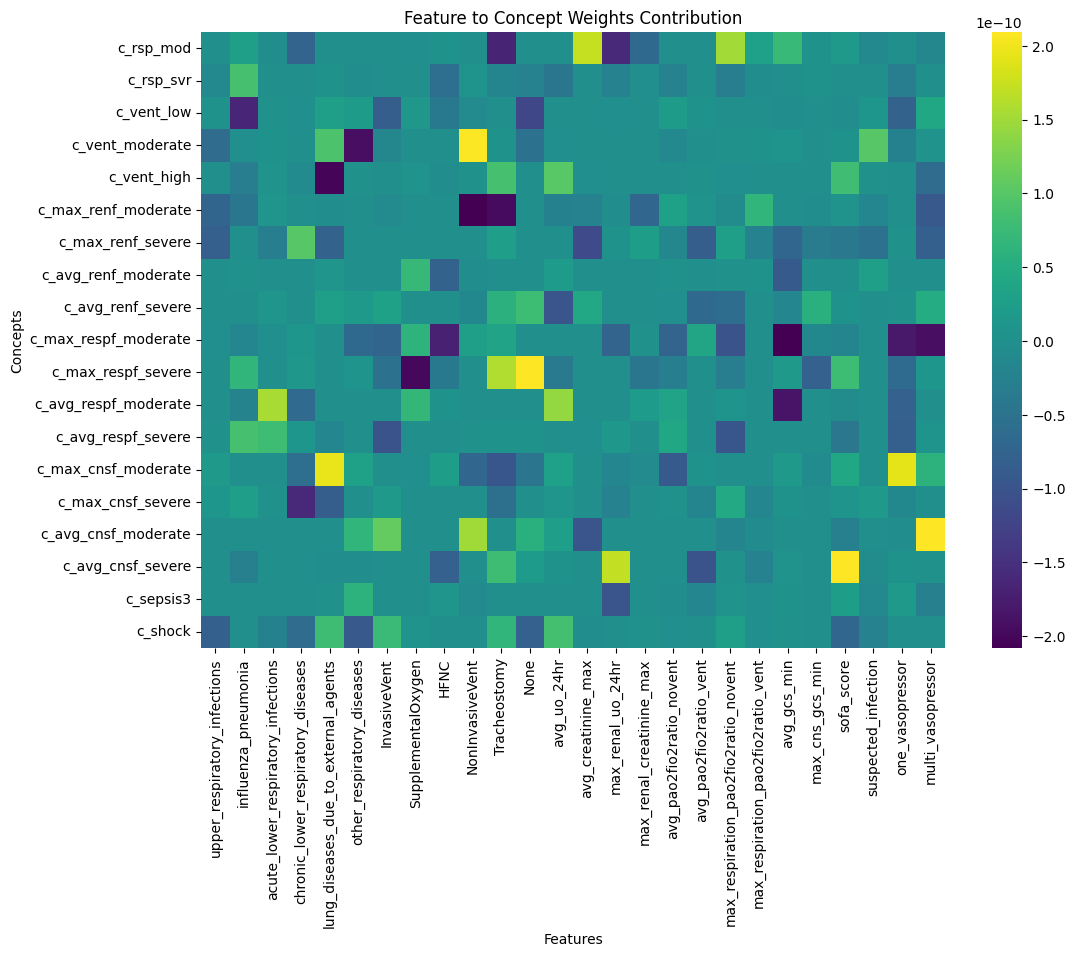

Feature to Concept Weights Contribution:
                      upper_respiratory_infections  influenza_pneumonia  \
c_rsp_mod                            -8.097954e-13         2.577624e-11   
c_rsp_svr                            -1.090851e-11         8.590326e-11   
c_vent_low                            5.076572e-12        -1.651684e-10   
c_vent_moderate                      -6.141016e-11        -1.873838e-12   
c_vent_high                          -1.942617e-13        -3.258152e-11   
c_max_renf_moderate                  -7.421293e-11        -4.445146e-11   
c_max_renf_severe                    -8.331894e-11        -7.008634e-17   
c_avg_renf_moderate                  -3.807684e-15         1.843875e-12   
c_avg_renf_severe                     1.398300e-17        -8.051462e-15   
c_max_respf_moderate                 -1.177463e-12        -1.705218e-11   
c_max_respf_severe                   -2.365412e-17         6.544448e-11   
c_avg_respf_moderate                  5.849552e-13        -

In [53]:
plt.figure(figsize=(12, 8))
sns.heatmap(feature_to_concept_contributions, cmap='viridis', cbar=True)
plt.title('Feature to Concept Weights Contribution')
plt.xlabel('Features')
plt.ylabel('Concepts')
plt.show()

print("Feature to Concept Weights Contribution:")
print(feature_to_concept_contributions)

B. Concept to Label

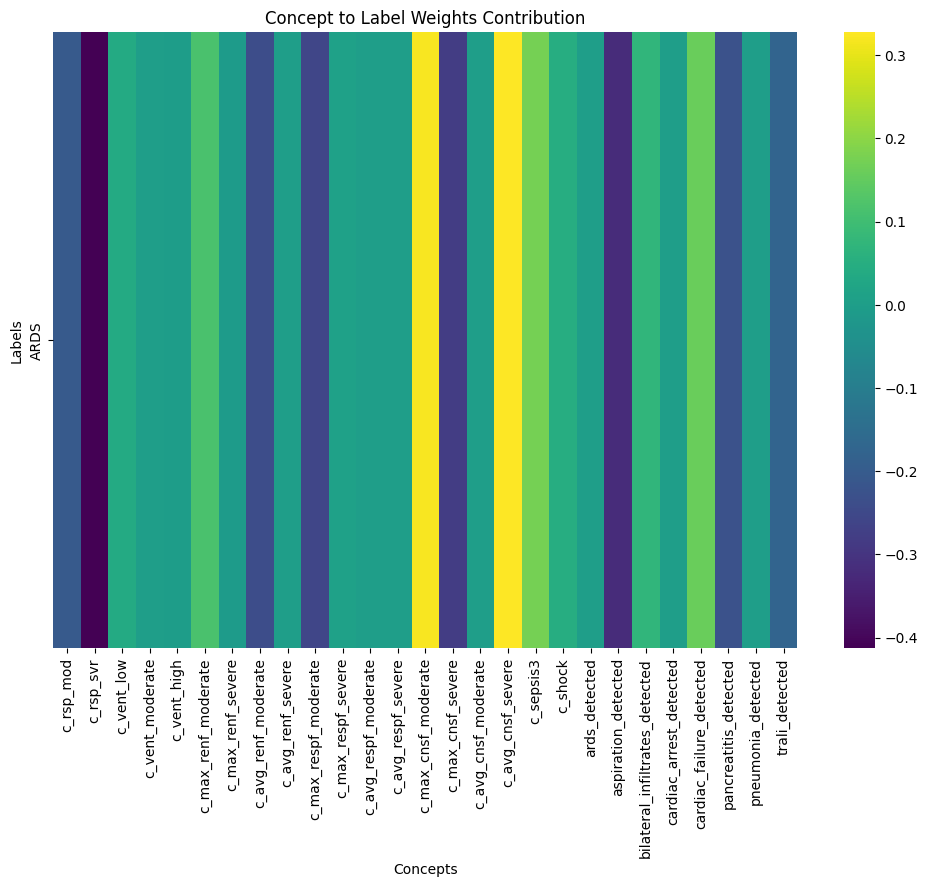

Concept to Label Weights Contribution:
      c_rsp_mod  c_rsp_svr  c_vent_low  c_vent_moderate  c_vent_high  \
ARDS  -0.204788  -0.412536    0.037482        -0.000055    -0.003516   

      c_max_renf_moderate  c_max_renf_severe  c_avg_renf_moderate  \
ARDS             0.114829          -0.008453             -0.24187   

      c_avg_renf_severe  c_max_respf_moderate  ...  c_sepsis3   c_shock  \
ARDS            0.00093              -0.25792  ...   0.174224  0.049648   

      ards_detected  aspiration_detected  bilateral_infiltrates_detected  \
ARDS      -0.000047            -0.320953                        0.070586   

      cardiac_arrest_detected  cardiac_failure_detected  \
ARDS                -0.000461                   0.15735   

      pancreatitis_detected  pneumonia_detected  trali_detected  
ARDS               -0.22621            0.000021       -0.177702  

[1 rows x 27 columns]


In [54]:
plt.figure(figsize=(12, 8))
sns.heatmap(concept_to_label_contributions, cmap='viridis', cbar=True)
plt.title('Concept to Label Weights Contribution')
plt.xlabel('Concepts')
plt.ylabel('Labels')
plt.show()

print("Concept to Label Weights Contribution:")
print(concept_to_label_contributions)

C. Combined Vanilla Feature - Vanilla Concept Pair to Label

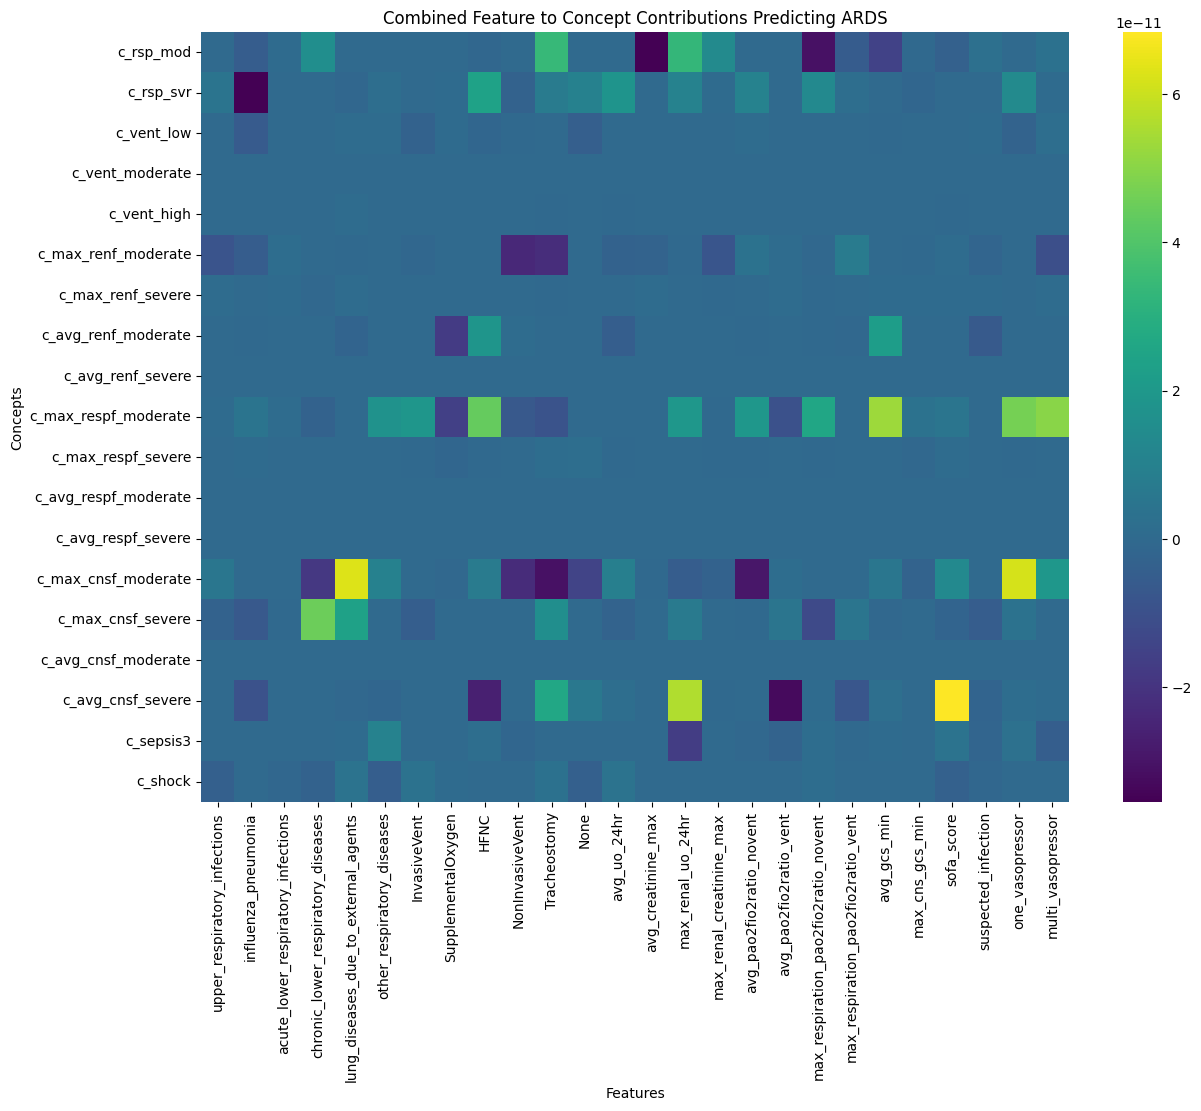

Combined Contributions Predicting ARDS:
                      upper_respiratory_infections  influenza_pneumonia  \
c_rsp_mod                             1.658363e-13        -5.278663e-12   
c_rsp_svr                             4.500156e-12        -3.543821e-11   
c_vent_low                            1.902811e-13        -6.190875e-12   
c_vent_moderate                       3.369434e-15         1.028132e-16   
c_vent_high                           6.831117e-16         1.145713e-13   
c_max_renf_moderate                  -8.521812e-12        -5.104326e-12   
c_max_renf_severe                     7.043296e-13         5.924689e-19   
c_avg_renf_moderate                   9.209653e-16        -4.459785e-13   
c_avg_renf_severe                     1.300522e-20        -7.488452e-18   
c_max_respf_moderate                  3.036906e-13         4.398090e-12   
c_max_respf_severe                   -2.036800e-19         5.635266e-13   
c_avg_respf_moderate                 -1.199934e-17         4

In [55]:
vanilla_concept_to_label_contributions = get_concept_to_label_weights(regularised_model, vanilla_concepts, label_names)

# Extract the weights for the label 'ARDS'
concept_to_label_weights = vanilla_concept_to_label_contributions.loc[label_names[0]].values

# Reshape concept_to_label_weights for element-wise multiplication
concept_to_label_weights = concept_to_label_weights.reshape(-1, 1)

# Calculate the combined contributions by element-wise multiplication
combined_contributions = feature_to_concept_contributions.values * concept_to_label_weights

# Create a DataFrame for the combined contributions
combined_df = pd.DataFrame(combined_contributions, index=vanilla_concepts, columns=feature_names)

# Plotting the combined heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(combined_df, cmap='viridis', cbar=True, fmt=".2f")
plt.title('Combined Feature to Concept Contributions Predicting ARDS')
plt.xlabel('Features')
plt.ylabel('Concepts')
plt.show()

print("Combined Contributions Predicting ARDS:")
print(combined_df)

## Previous Attempts

Differences in Code:

CODE 1 does row-wise normalisation. CODE 2 does column-wise normalisation.
* When visualized using heatmaps, row-wise normalization will show the importance of each feature across all concepts or each concept across all outputs.
* When visualized using heatmaps, column-wise normalization will show the importance of each feature for a specific concept or each concept for a specific output.

CODE 1 implements vertical heatmap. CODE 2 implements horizontal heatmap.
* Vertical: Easier to see which features have the most impact across multiple concepts by looking at each row. Easier to see which concepts have the most impact on the output by looking at each row.
* Horizontal: Easier to see which concepts are most influenced by each feature by looking across each row. Easier to see which outputs are most influenced by each concept by looking across each row.

CODE 1



```
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract weights from vanilla_c_predictor model (input features to concepts)
input_to_concept_weights = regularised_model.vanilla_c_predictor.layer1.weight.detach().cpu().numpy()

# Extract weights from label_predictor model (concepts to output)
concept_to_output_weights = regularised_model.label_predictor.layer1.weight.detach().cpu().numpy()

# Normalize the weights for better visualization
input_to_concept_weights_norm = np.linalg.norm(input_to_concept_weights, axis=1)
concept_to_output_weights_norm = np.linalg.norm(concept_to_output_weights, axis=1)

# Get feature and concept names
features = data_processor.X.columns.tolist()
vanilla_concepts = data_processor.C.columns.tolist()
llm_concepts = data_processor.LLM_C.columns.tolist()
all_concepts = vanilla_concepts + llm_concepts

# Adjust the aspect ratio and size for better readability
plt.figure(figsize=(12, 8))
sns.heatmap(input_to_concept_weights_norm.reshape(-1, 1), cmap="viridis", yticklabels=features, cbar_kws={'label': 'Weight'})
plt.title("Input Features to Concepts Weights")
plt.xlabel("Concepts")
plt.ylabel("Input Features")
plt.tight_layout()
plt.show()

# Concatenate vanilla and LLM concepts weights for visualization
all_concept_weights_norm = np.concatenate([concept_to_output_weights_norm, np.zeros(len(llm_concepts))])

# Adjust the aspect ratio and size for better readability
plt.figure(figsize=(12, 8))
sns.heatmap(all_concept_weights_norm.reshape(-1, 1), cmap="viridis", yticklabels=all_concepts, cbar_kws={'label': 'Weight'})
plt.title("Concepts to Output Weights")
plt.xlabel("Output (ARDS)")
plt.ylabel("Concepts")
plt.tight_layout()
plt.show()

# Print the normalized weights
print("Normalized Weights from Input Features to Concepts:")
for feature, weight in zip(features, input_to_concept_weights_norm):
    print(f"{feature}: {weight}")

print("\nNormalized Weights from Concepts to Output (ARDS):")
for concept, weight in zip(all_concepts, all_concept_weights_norm):
    print(f"{concept}: {weight}")

```



CODE 2



```
# Extract weights from vanilla_c_predictor model (input features to concepts)
input_to_concept_weights = regularised_model.vanilla_c_predictor.layer1.weight.detach().cpu().numpy()

# Extract weights from label_predictor model (concepts to output)
concept_to_output_weights = regularised_model.label_predictor.layer1.weight.detach().cpu().numpy()

# Normalize the weights for better visualization
input_to_concept_weights_norm = np.linalg.norm(input_to_concept_weights, axis=0)
concept_to_output_weights_norm = np.linalg.norm(concept_to_output_weights, axis=0)

# Get feature and concept names
features = data_processor.X.columns.tolist()
vanilla_concepts = data_processor.C.columns.tolist()
llm_concepts = data_processor.LLM_C.columns.tolist()
all_concepts = vanilla_concepts + llm_concepts

# Visualize input to concept weights
plt.figure(figsize=(12, 8))
sns.heatmap(input_to_concept_weights.T, cmap="viridis", yticklabels=features)
plt.title("Input Features to Concepts Weights")
plt.xlabel("Concepts")
plt.ylabel("Input Features")
plt.tight_layout()
plt.show()

# Visualize concept to output weights
plt.figure(figsize=(12, 8))
sns.heatmap(concept_to_output_weights.T, cmap="viridis", yticklabels=all_concepts)
plt.title("Concepts to Output Weights")
plt.xlabel("Output (ARDS)")
plt.ylabel("Concepts")
plt.tight_layout()
plt.show()

# Print the normalized weights
print("Normalized Weights from Input Features to Concepts:")
for feature, weight in zip(features, input_to_concept_weights_norm):
    print(f"{feature}: {weight}")

print("\nNormalized Weights from Concepts to Output (ARDS):")
for concept, weight in zip(all_concepts, concept_to_output_weights_norm):
    print(f"{concept}: {weight}")

```



High Weights (Yellow): Indicates that the corresponding input feature has a strong positive influence on the concept.
Low Weights (Dark Purple): Indicates that the corresponding input feature has a strong negative influence on the concept.
Weights Close to Zero (Green/Blue): Indicates that the corresponding input feature has little to no influence on the concept.


EXAMPLE INTERPRETIATION:
* Diverse Influence: The heatmap shows a mix of positive, negative, and neutral weights across different features and concepts, indicating a complex relationship.
* Specific Influences: Some features have strong weights (yellow or dark purple) for specific concepts, highlighting their significant influence on those concepts.
* General Trends: Features like avg_uo_24hr, sofa_score, and suspected_infection show varied influence across multiple concepts, suggesting their broader relevance.


Strong Positive Influence:

For example, if you see a bright yellow spot in the row for upper_respiratory_infections and column 10, it means this feature strongly and positively influences concept 10.
Strong Negative Influence:

If you see a dark purple spot in the row for avg_creatinine_max and column 15, it means this feature strongly and negatively influences concept 15.
Minimal Influence:

Green/blue spots across features like NonInvasiveVent for many concepts suggest these features do not significantly impact those concepts.